# Imports

In [181]:
import time
import pandas as pd
import numpy as np
import ast
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
import nltk
from nltk import corpus, tokenize, stem
from sklearn.feature_extraction.text import TfidfVectorizer


In [182]:
init_time = time.time()

# Chargement de données

In [183]:
# !tree

In [184]:
path = "data/Flipkart/"

In [185]:
data = pd.read_csv(path+'flipkart_com-ecommerce_sample_1050.csv')

# Analyse exploraoire & pretraitement des données

In [186]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')
stop_words = set(corpus.stopwords.words('english'))

wordnet_map = {"N":corpus.wordnet.NOUN, "V":corpus.wordnet.VERB, "J":corpus.wordnet.ADJ, "R":corpus.wordnet.ADV}

def tokenize_document(document):
    # Transformer le document en lowercase
    document = document.lower().strip()

    # Tokeniser le document
    tokens = tokenize.word_tokenize(document)

    # Supprimer les stop-words
    tokens = [token for token in tokens if token not in stop_words]

    # Supprimer les caractéres non alpha numerique
    tokens = [token for token in tokens if token.isalpha()]

    return tokens


def stemming_document(tokenized_doc):

    stemmer = nltk.PorterStemmer()

    stems = [stemmer.stem(t) for t in tokenized_doc]

    return stems



    
train_sents = corpus.brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, corpus.wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text


def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = stem.WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/amadousy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amadousy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amadousy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /home/amadousy/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [187]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [188]:
data.tail()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [190]:
data.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [191]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

## | Documents manquants et/ou dupliqués

In [192]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

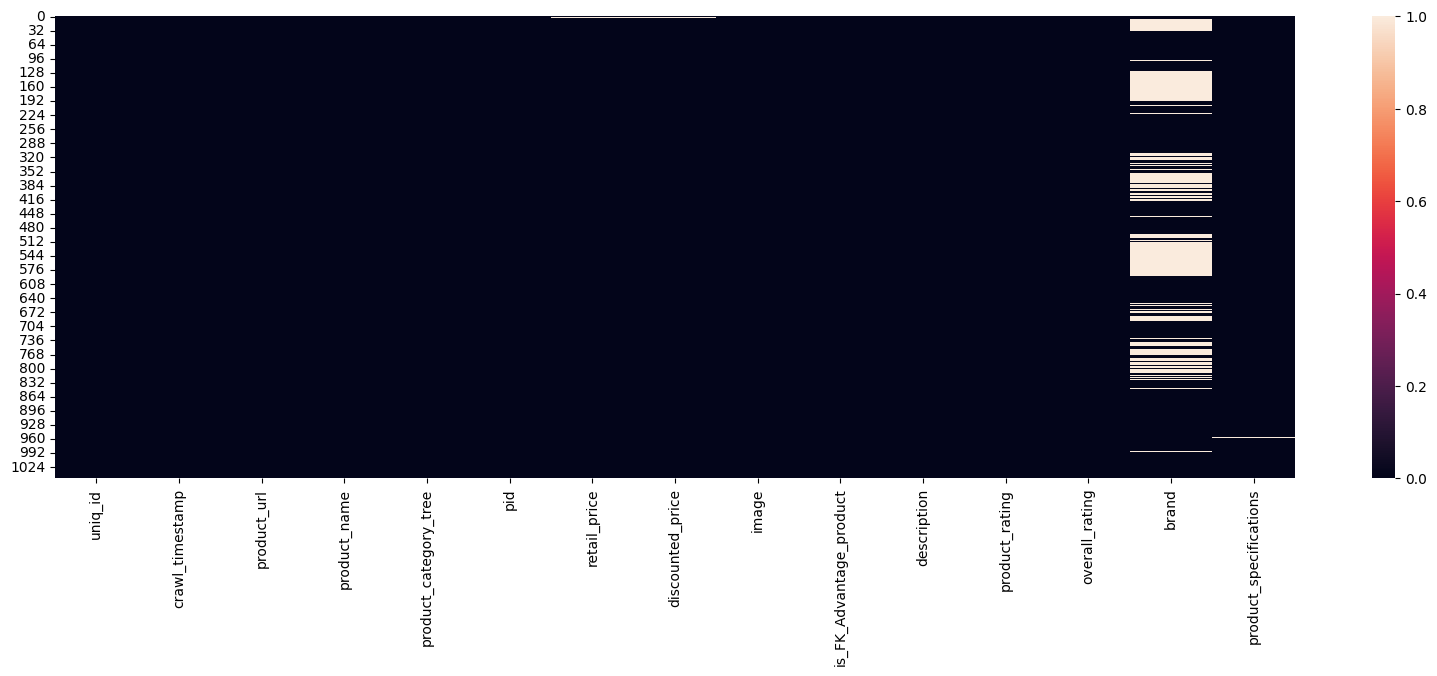

In [193]:
fig, _ = plt.subplots(1, 1, figsize=(20, 6))
sns.heatmap(data.isna())
plt.show()

In [194]:
data.duplicated(subset='uniq_id').sum()

np.int64(0)

## | variable: product_category_tree

In [195]:
data.product_category_tree.describe()

count                                                  1050
unique                                                  642
top       ["Home Furnishing >> Bed Linen >> Blankets, Qu...
freq                                                     56
Name: product_category_tree, dtype: object

In [196]:
data.product_category_tree[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

On observe que la variable product_category_tree contient une liste de ctégorie pour chaque produit.

Nous allons explorer les categories.

In [197]:
def get_len_category(doc):
    doc = doc.replace('[', '').replace(']', '').strip('"')
    categories = doc.split(">>")
    categories = [cat.strip() for cat in categories]
    return len(set(categories))


def get_categorie(doc):
    doc = doc.replace('[', '').replace(']', '').strip('"')
    categories = doc.split(">>")
    categories = [cat.strip() for cat in categories]
    return categories[0]
    
    
tmp = data.product_category_tree.apply(get_len_category)

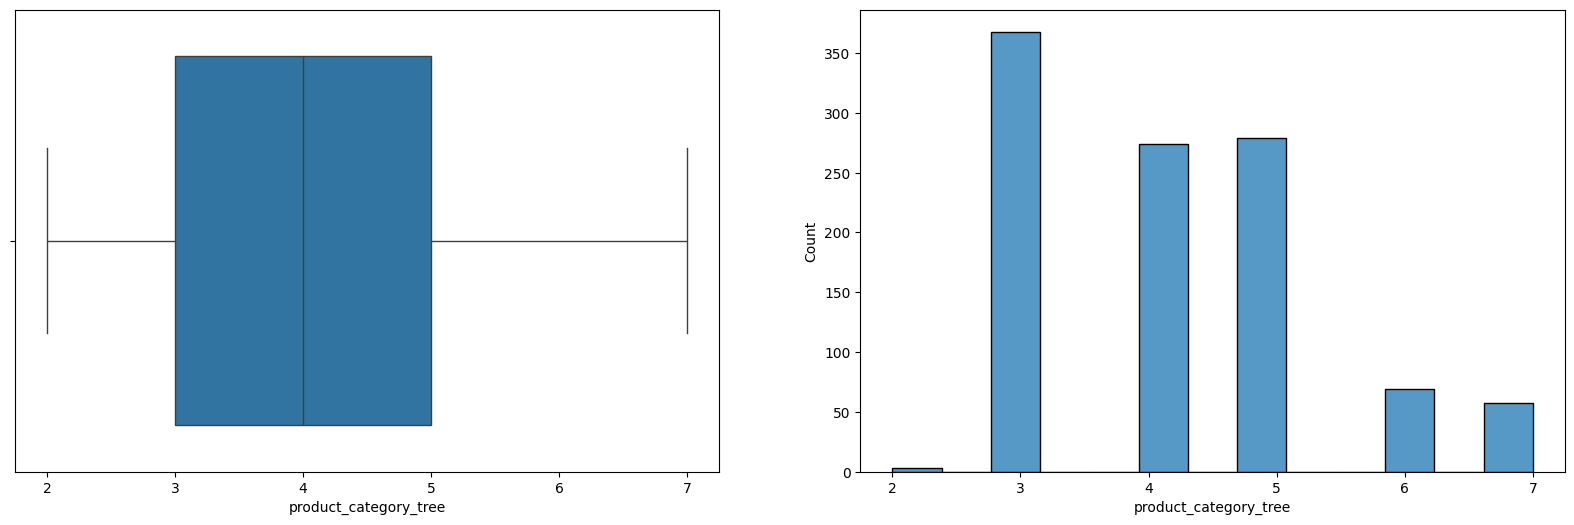

In [198]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(x=tmp, ax=ax0)
sns.histplot(tmp, ax=ax1)
plt.show()

In [199]:
tmp.describe()

count    1050.000000
mean        4.203810
std         1.157058
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: product_category_tree, dtype: float64

Un produit à au minimum deux categories et au plus 7

In [200]:
tmp.value_counts()

product_category_tree
3    368
5    279
4    274
6     69
7     57
2      3
Name: count, dtype: int64

In [201]:
data['category'] = data['product_category_tree'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

In [202]:
data.category.value_counts()

category
Home Furnishing             150
Baby Care                   150
Watches                     150
Home Decor                  150
Kitchen                     150
Beauty and Personal Care    150
Computers                   150
Name: count, dtype: int64

In [203]:
p = data.loc[data.category == 'Home Furnishing', ]
p.iloc[0]['uniq_id']

'55b85ea15a1536d46b7190ad6fff8ce7'

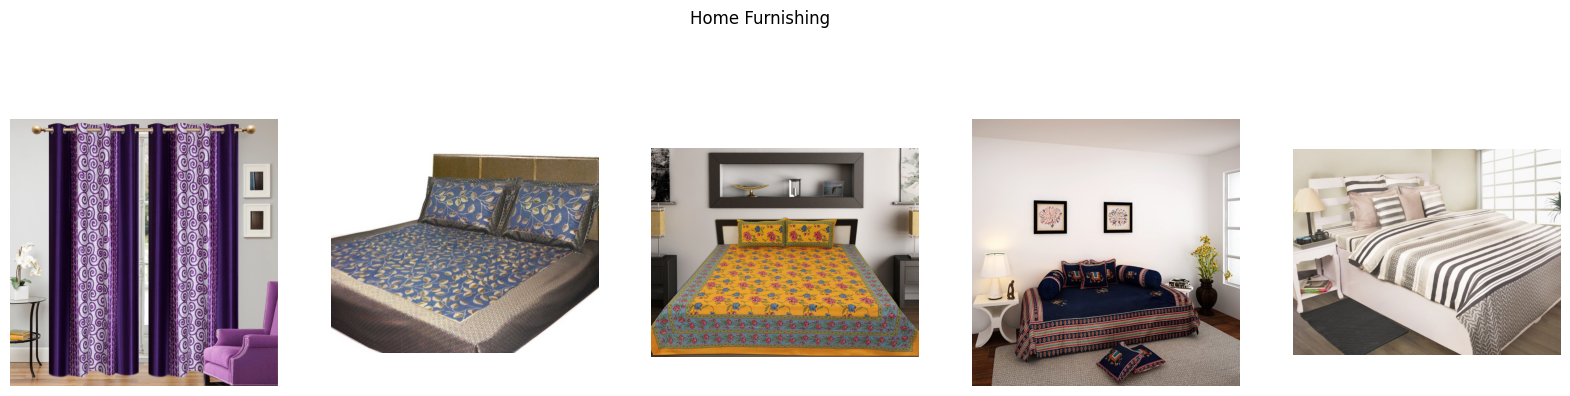

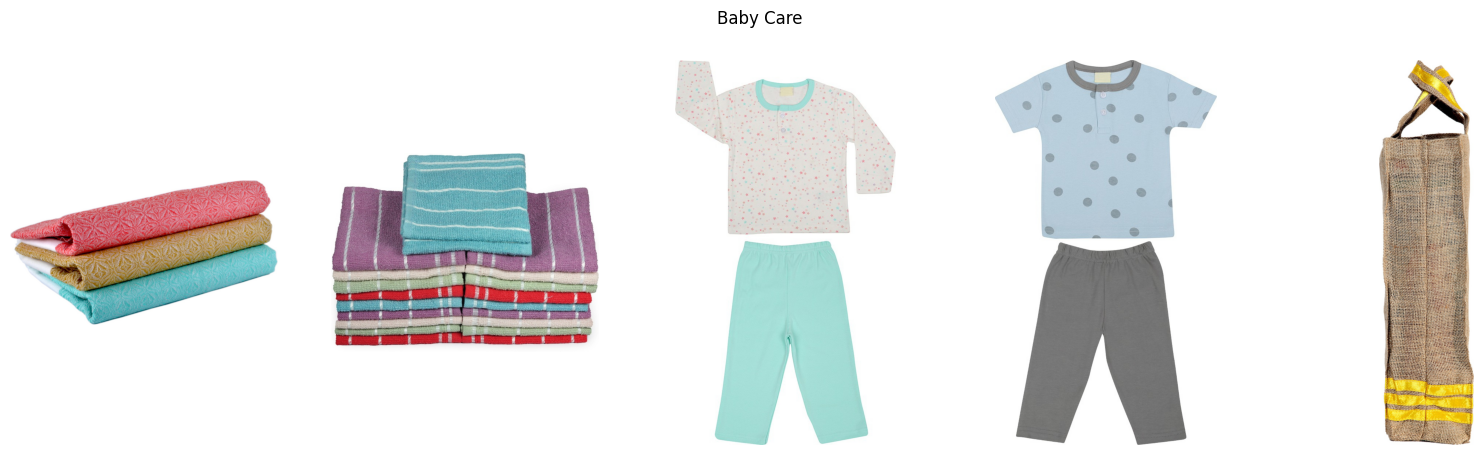

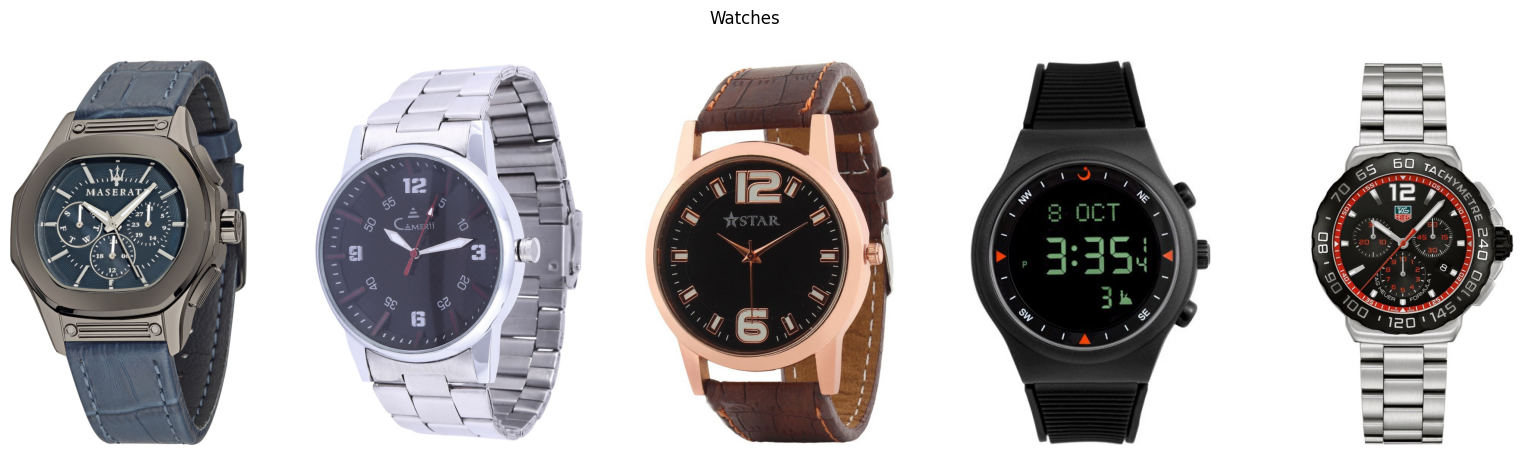

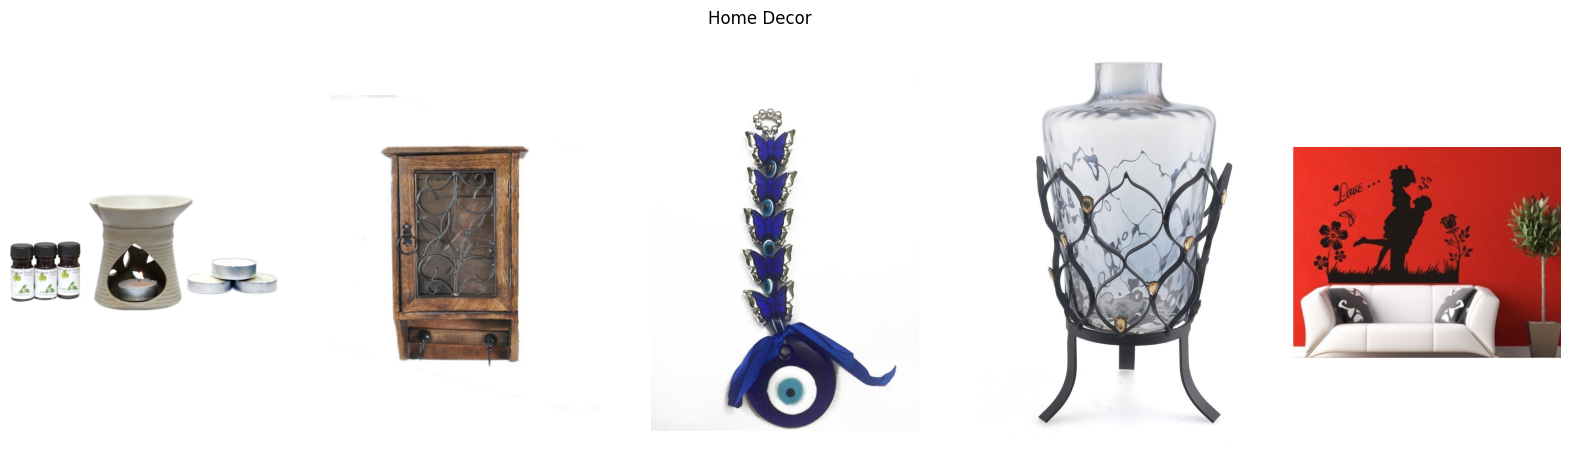

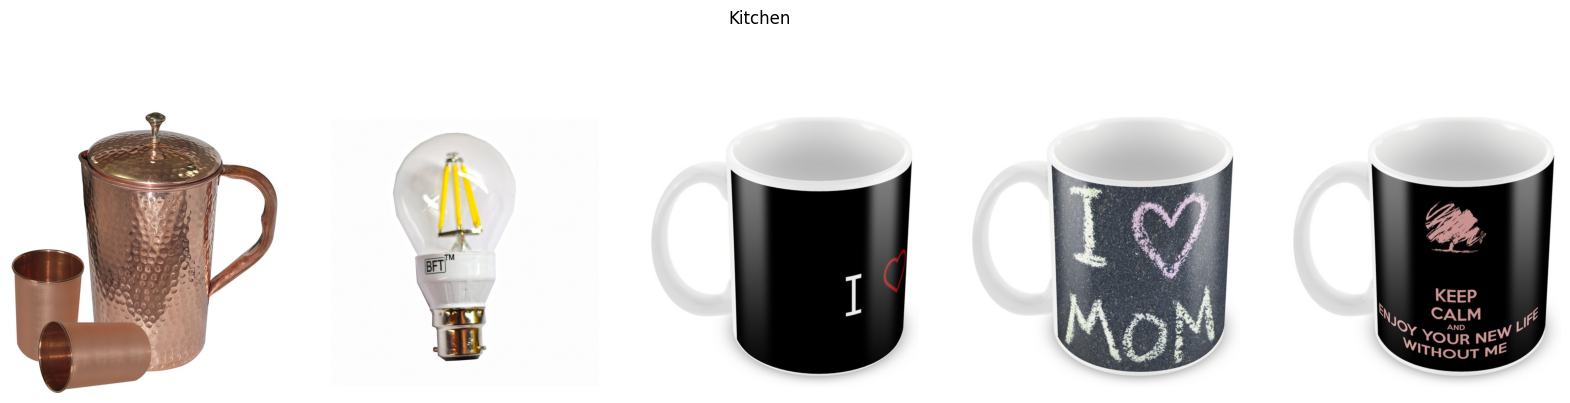

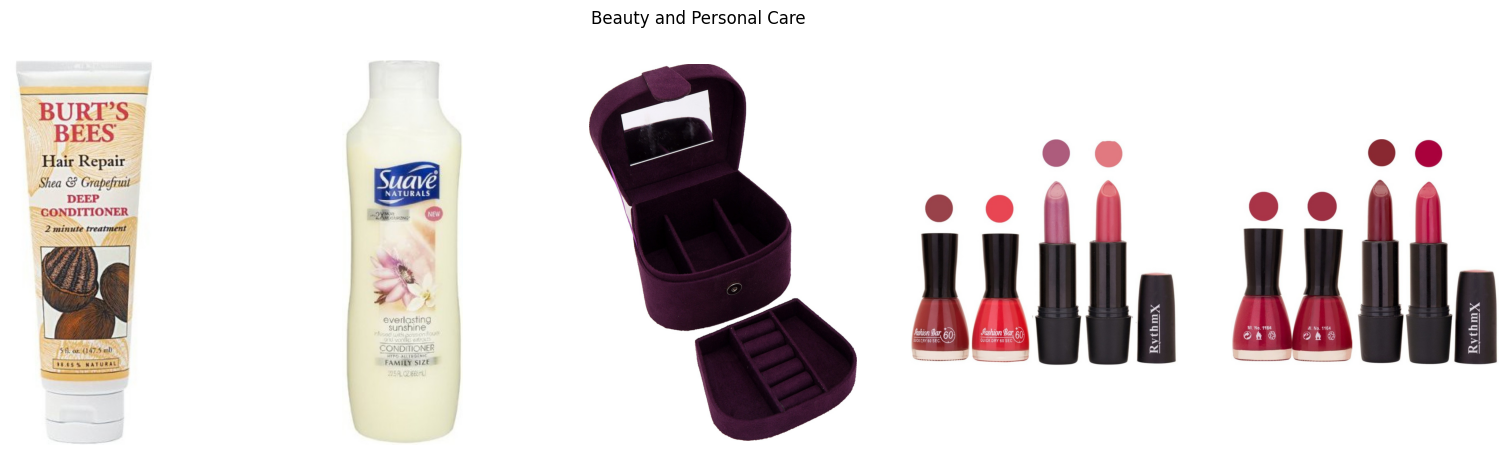

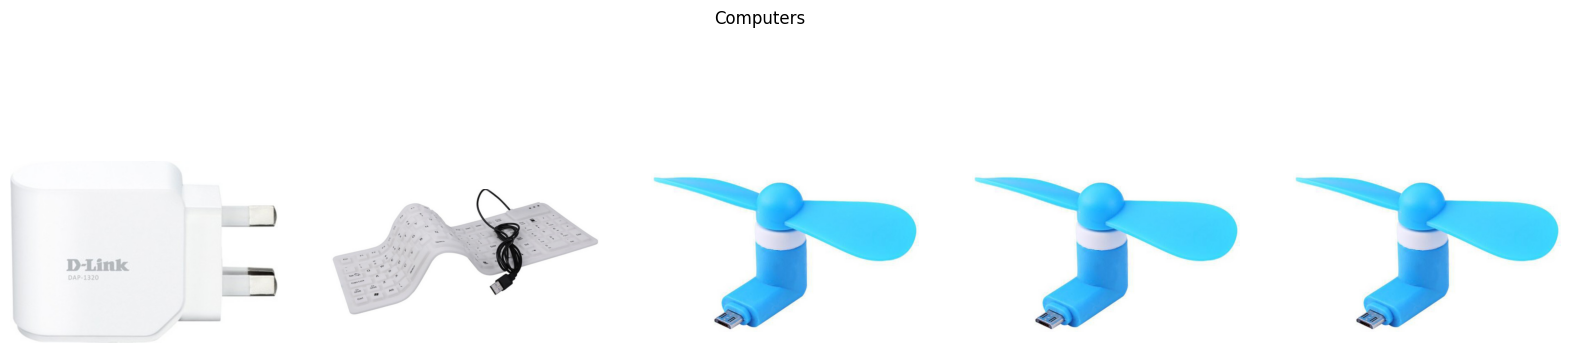

In [204]:
# Affichage image de categorie

for i, category in enumerate(data.category.unique()):
    products = data.loc[data.category == category, ]
    fig = plt.figure(figsize = (20, 5))
    for j in range(5):
        p = products.iloc[j]
        plt.subplot(150 + 1 + j)
        filename = path+"Images/"+p['uniq_id']+".jpg"
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(category)
    plt.show()

## | variable: description

In [205]:
data.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing


In [206]:
data.description.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1050 entries, 0 to 1049
Series name: description
Non-Null Count  Dtype 
--------------  ----- 
1050 non-null   object
dtypes: object(1)
memory usage: 8.3+ KB


In [207]:
data.description.describe()

count                                                  1050
unique                                                 1050
top       Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
freq                                                      1
Name: description, dtype: object

### Tokenization

In [208]:
data['tokenized_description'] = data.description.apply(tokenize_document)

In [209]:
data.tokenized_description

0       [key, features, elegance, polyester, multicolo...
1       [specifications, sathiyas, cotton, bath, towel...
2       [key, features, eurospa, cotton, terry, face, ...
3       [key, features, santosh, royal, fashion, cotto...
4       [key, features, jaipur, print, cotton, floral,...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, online,...
Name: tokenized_description, Length: 1050, dtype: object

### Stemming

In [210]:
data['stemmed_description'] = data.tokenized_description.apply(stemming_document)

In [211]:
data.stemmed_description

0       [key, featur, eleg, polyest, multicolor, abstr...
1       [specif, sathiya, cotton, bath, towel, bath, t...
2       [key, featur, eurospa, cotton, terri, face, to...
3       [key, featur, santosh, royal, fashion, cotton,...
4       [key, featur, jaipur, print, cotton, floral, k...
                              ...                        
1045    [oren, empow, extra, larg, self, adhes, sticke...
1046    [wallmantra, larg, vinyl, sticker, sticker, pa...
1047    [buy, uberlyf, extra, larg, pigment, polyvinyl...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyf, larg, vinyl, sticker, onlin, ub...
Name: stemmed_description, Length: 1050, dtype: object

### Part of Speech Tagging (POS Tagging)

In [212]:
pos_tag_wordnet(data.tokenized_description[2])[:10]

[('key', 'n'),
 ('features', 'v'),
 ('eurospa', 'n'),
 ('cotton', 'n'),
 ('terry', 'n'),
 ('face', 'v'),
 ('towel', 'n'),
 ('set', 'v'),
 ('size', 'n'),
 ('small', 'a')]

In [213]:
data['combined_postag_wnet'] = data.tokenized_description.apply(lambda x: pos_tag_wordnet(x))

In [214]:
data.combined_postag_wnet

0       [(key, n), (features, v), (elegance, n), (poly...
1       [(specifications, n), (sathiyas, n), (cotton, ...
2       [(key, n), (features, v), (eurospa, n), (cotto...
3       [(key, n), (features, v), (santosh, n), (royal...
4       [(key, n), (features, v), (jaipur, n), (print,...
                              ...                        
1045    [(oren, n), (empower, n), (extra, a), (large, ...
1046    [(wallmantra, n), (large, a), (vinyl, n), (sti...
1047    [(buy, v), (uberlyfe, n), (extra, a), (large, ...
1048    [(buy, v), (wallmantra, n), (medium, n), (viny...
1049    [(buy, v), (uberlyfe, n), (large, a), (vinyl, ...
Name: combined_postag_wnet, Length: 1050, dtype: object

### Lemmatization

In [215]:
data['lemmatized_description'] = data.combined_postag_wnet.apply(lemmatize_word)
data['lemmatized_description_text'] = [' '.join(map(str, l)) for l in data['lemmatized_description']]

In [216]:
data['lemmatized_description_text']

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel bath ...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker on...
1049    buy uberlyfe large vinyl sticker online uberly...
Name: lemmatized_description_text, Length: 1050, dtype: object

In [217]:
# Comparaison entre le texte original et le texte lemmatisé
display(data["description"][0])
print("----"*10)
display(data["lemmatized_description_text"][0])

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

----------------------------------------


'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look curtain make high quality polyester feature eyelet style stitch metal make room environment romantic curtain wrinkle anti shrinkage elegant home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty give soothing print bring home elegant curtain softly filter light room get right amount specification elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance design door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length cm box number content sale package pack sale package curtain body design material polye

## | variable: product_name

In [218]:
data.product_name.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1050 entries, 0 to 1049
Series name: product_name
Non-Null Count  Dtype 
--------------  ----- 
1050 non-null   object
dtypes: object(1)
memory usage: 8.3+ KB


In [219]:
data.product_name.head()

0    Elegance Polyester Multicolor Abstract Eyelet ...
1                           Sathiyas Cotton Bath Towel
2                  Eurospa Cotton Terry Face Towel Set
3    SANTOSH ROYAL FASHION Cotton Printed King size...
4    Jaipur Print Cotton Floral King sized Double B...
Name: product_name, dtype: object

### Tokenisation

In [220]:
data['tokenized_product_name'] = data.product_name.apply(tokenize_document)

In [221]:
data.tokenized_product_name

0       [elegance, polyester, multicolor, abstract, ey...
1                         [sathiyas, cotton, bath, towel]
2              [eurospa, cotton, terry, face, towel, set]
3       [santosh, royal, fashion, cotton, printed, kin...
4       [jaipur, print, cotton, floral, king, sized, d...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046         [wallmantra, large, vinyl, sticker, sticker]
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048        [wallmantra, medium, vinyl, sticker, sticker]
1049                    [uberlyfe, large, vinyl, sticker]
Name: tokenized_product_name, Length: 1050, dtype: object

### Part of Speech Tagging (POS Tagging)

In [222]:
pos_tag_wordnet(data.tokenized_product_name[2])[:10]

[('eurospa', 'n'),
 ('cotton', 'n'),
 ('terry', 'n'),
 ('face', 'v'),
 ('towel', 'n'),
 ('set', 'v')]

In [223]:
data['combined_postag_wnet_product_name'] = data.tokenized_product_name.apply(lambda x: pos_tag_wordnet(x))

In [224]:
data.combined_postag_wnet_product_name

0       [(elegance, n), (polyester, n), (multicolor, n...
1       [(sathiyas, n), (cotton, n), (bath, n), (towel...
2       [(eurospa, n), (cotton, n), (terry, n), (face,...
3       [(santosh, n), (royal, a), (fashion, n), (cott...
4       [(jaipur, n), (print, n), (cotton, n), (floral...
                              ...                        
1045    [(oren, n), (empower, n), (extra, a), (large, ...
1046    [(wallmantra, n), (large, a), (vinyl, n), (sti...
1047    [(uberlyfe, n), (extra, a), (large, a), (pigme...
1048    [(wallmantra, n), (medium, n), (vinyl, n), (st...
1049    [(uberlyfe, n), (large, a), (vinyl, n), (stick...
Name: combined_postag_wnet_product_name, Length: 1050, dtype: object

### Lemmatization

In [225]:
data['lemmatized_product_name'] = data.combined_postag_wnet_product_name.apply(lemmatize_word)
data['lemmatized_product_name_text'] = [' '.join(map(str, l)) for l in data['lemmatized_product_name']]

In [226]:
data.lemmatized_product_name_text

0       elegance polyester multicolor abstract eyelet ...
1                              sathiyas cotton bath towel
2                     eurospa cotton terry face towel set
3       santosh royal fashion cotton print king sized ...
4       jaipur print cotton floral king sized double b...
                              ...                        
1045       oren empower extra large self adhesive sticker
1046               wallmantra large vinyl sticker sticker
1047    uberlyfe extra large pigmented polyvinyl film ...
1048              wallmantra medium vinyl sticker sticker
1049                         uberlyfe large vinyl sticker
Name: lemmatized_product_name_text, Length: 1050, dtype: object

In [227]:
# Comparaison entre le texte original et le texte lemmatisé
display(data["product_name"][3])
print("----"*10)
display(data["lemmatized_product_name_text"][3])

'SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet'

----------------------------------------


'santosh royal fashion cotton print king sized double bedsheet'

# Extraction des caracteristiques

## TF-IDF

In [228]:
def print_out(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    #print(feat.get_feature_names(), "\n")
    #print(ngram,"bag-of-feature: ")
    #print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names()).head(), "\n")
    print(ngram,"vector example:")
    print(train_df["lemmatize_text"][compared_sentence])
    print(emb[compared_sentence], "\n")

In [229]:
def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [234]:
description_corpus = data.lemmatized_description_text.tolist()
train_df_tfidf_1gram, tfidf_1gram = TFIDF(description_corpus, 1)
train_df_tfidf_2gram, tfidf_2gram = TFIDF(description_corpus, 2)
train_df_tfidf_3gram, tfidf_3gram = TFIDF(description_corpus, 3)

print(len(description_corpus))
print(train_df_tfidf_1gram.shape)
print(train_df_tfidf_2gram.shape)
print(train_df_tfidf_3gram.shape)

tf-idf with 4133 features
tf-idf with 16964 features
tf-idf with 21881 features
1050
(1050, 4133)
(1050, 16964)
(1050, 21881)


In [231]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=11.540262937545776 seconds
